<a href="https://colab.research.google.com/github/syifafatma/Indonesia-inflation-rate-prediction/blob/main/nyobain_lstm%20(ver%201).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
# !pip install openpyxl

In [ ]:
github_url = 'https://raw.githubusercontent.com/syifafatma/Dataset-Inflasi/main/data_inflasi.xlsx'

# load dataset from github
my_file = requests.get(github_url)

# save file to buffer and read as pandas
with open('data_inflasi.xlsx', 'wb') as file:
  file.write(my_file.content)
dataset = pd.read_excel(my_file.content, engine='openpyxl')
print(dataset)

<ipython-input-2-faf37f2a0cc9>:9: FutureWarning: Passing bytes to 'read_excel' is deprecated and will be removed in a future version. To read from a byte string, wrap it in a `BytesIO` object.
  dataset = pd.read_excel(my_file.content, engine='openpyxl')


            Periode Inflasi
0      Oktober 2024  1.71 %
1    September 2024  1.84 %
2      Agustus 2024  2.12 %
3         Juli 2024  2.13 %
4         Juni 2024  2.51 %
..              ...     ...
258      April 2003  7.62 %
259      Maret 2003  7.17 %
260   Februari 2003   7.6 %
261    Januari 2003  8.68 %
262   Desember 2002     0 %

[263 rows x 2 columns]


In [ ]:
# sort the data in descending order (bawah ke atas)
dataset = dataset[::-1].reset_index(drop=True)

time_step = np.arange(len(dataset))
inflation = dataset['Inflasi'].str.replace('%', '').astype(float)

time = np.array(time_step)
x = np.array(inflation)

In [ ]:
print(time)
print(x)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
   # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

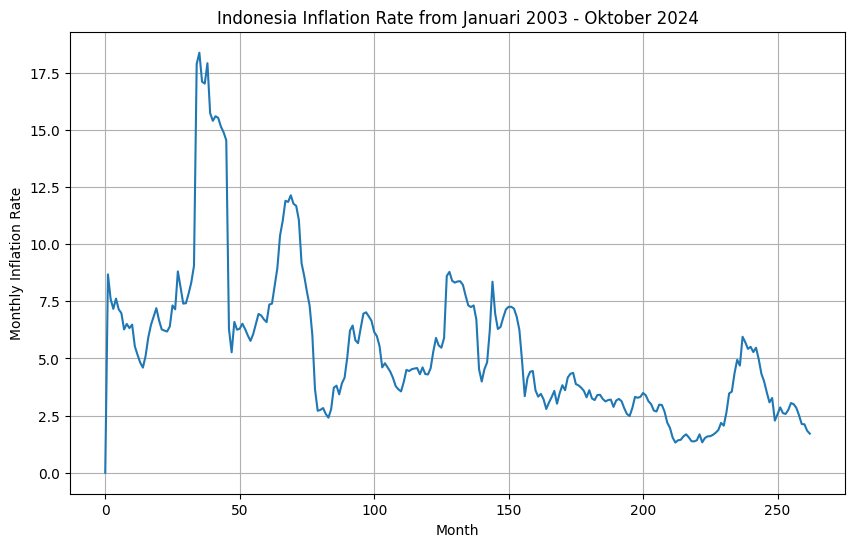

In [ ]:
# preview the data
plot_series(time, x, xlabel='Month', ylabel='Monthly Inflation Rate', title='Indonesia Inflation Rate from Januari 2003 - Oktober 2024')

In [ ]:
# split the dataset
split_time = 200

time_train = time[:split_time]
x_train = x[:split_time]

time_valid = time[split_time:]
x_valid = x[split_time:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size)

    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)

    return dataset

In [ ]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 200

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1,
                           padding="causal", activation="relu"),
    tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 20, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 20, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,465 (462.75 KB)

 Trainable params: 118,465 (462.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# build and train the dataset
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])

history = model.fit(train_set, epochs=100)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 5.8518 - mae: 6.3518
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.8263 - mae: 5.3262
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.1639 - mae: 3.6322
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0531 - mae: 2.5217
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9904 - mae: 2.4176
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9306 - mae: 2.3881
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.9144 - mae: 2.3946
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.8194 - mae: 2.2962
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4896 - mae: 1.9245
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.1145 - mae: 1.4743
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9064 - mae: 1.2386
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7774 - mae: 1.1183
Epoch 13/100
12/12 ━━━━━━

In [ ]:
# model prediction

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)

    return forecast

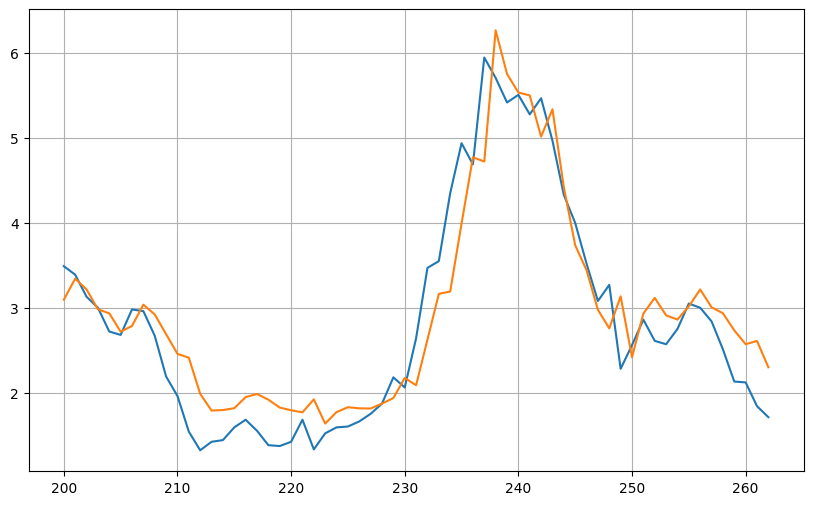

In [ ]:
# Reduce the original series
forecast_series = x[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

0.3513361
